In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
import dataframe_image as dfi

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, \
        confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import imblearn.over_sampling
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier
import xgboost as xgb

In [4]:
train = pd.read_csv('./healthcare/train_data.csv')

### Notebook contents

>1. Initial data cleaning
2. Training classifier algorithms
3. Random Forest hyperparameter tuning
4. Comparing all model results
5. Testing holdout set predictions

## 1. Initial data cleaning

In [5]:
train = train.rename(columns={'City_Code_Hospital': 'Hospital_city_code',
                              'Available Extra Rooms in Hospital': 'Extra_rooms',
                              'Bed Grade': 'Bed_grade',
                              'City_Code_Patient': 'Patient_city_code',
                              'Type of Admission': 'Admission_type',
                              'Severity of Illness': 'Severity',
                              'Visitors with Patient': 'Visitors'
                             })
train.columns = train.columns.str.lower()

In [6]:
train.head()

,case_id,hospital_code,hospital_type_code,hospital_city_code,hospital_region_code,extra_rooms,department,ward_type,ward_facility_code,bed_grade,patientid,patient_city_code,admission_type,severity,visitors,age,admission_deposit,stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   case_id               318438 non-null  int64  
 1   hospital_code         318438 non-null  int64  
 2   hospital_type_code    318438 non-null  object 
 3   hospital_city_code    318438 non-null  int64  
 4   hospital_region_code  318438 non-null  object 
 5   extra_rooms           318438 non-null  int64  
 6   department            318438 non-null  object 
 7   ward_type             318438 non-null  object 
 8   ward_facility_code    318438 non-null  object 
 9   bed_grade             318325 non-null  float64
 10  patientid             318438 non-null  int64  
 11  patient_city_code     313906 non-null  float64
 12  admission_type        318438 non-null  object 
 13  severity              318438 non-null  object 
 14  visitors              318438 non-null  int64  
 15  

In [8]:
# no duplicates
train.shape, train.drop_duplicates().shape

((318438, 18), (318438, 18))

In [9]:
# hold out 20%

train, holdout, y_train, y_holdout = train_test_split(train.drop('stay', axis=1), train['stay'], 
                                                   test_size=0.2, stratify=train['stay'])

In [10]:
# columns with null values

num_missing = train.loc[:,train.isna().any()].isna().sum()
num_missing

bed_grade              84
patient_city_code    3616
dtype: int64

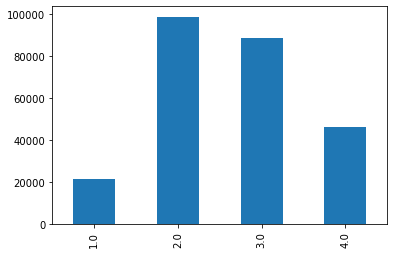

In [11]:
train.bed_grade.value_counts().sort_index().plot(kind='bar')

In [12]:
# replacing missing values with a random sample from non-null values
for df in [train, holdout]:
    num_missing = df.loc[:,df.isna().any()].isna().sum()[0]
    df.loc[df.bed_grade.isna(),'bed_grade'] = df.bed_grade.dropna().sample(n=num_missing).to_list()

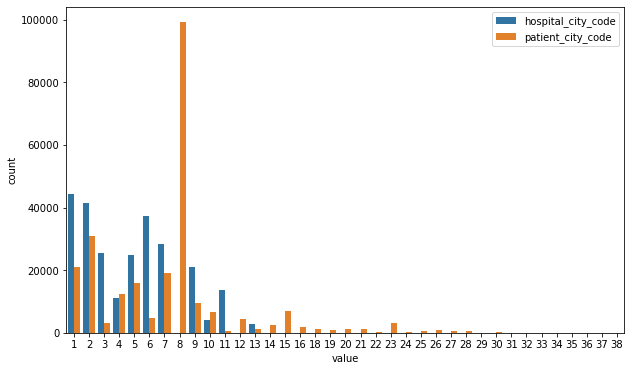

In [13]:
# distribution of city code values

fig, ax=plt.subplots(figsize=(10,6))
df = train[['hospital_city_code', 'patient_city_code']].melt().dropna()
df['value'] = df['value'].astype(int)
sns.countplot(data=df, x='value', hue='variable',
             ax=ax)
plt.legend(loc='upper right')

In [14]:
# Treat cities coded over 15 (fewer records in above distribution) as "other" to combine smaller categories
for col in ['hospital_city_code', 'patient_city_code']:
    train[col] = train[col].apply(lambda x: 16 if (x > 15 or pd.isna(x)) else x) 
    holdout[col] = holdout[col].apply(lambda x: 16 if (x > 15 or pd.isna(x)) else x) 

In [15]:
# Convert to categorical
for df in [train, holdout]:
    df[['hospital_city_code', 'patient_city_code']] = df[['hospital_city_code', 
                                                          'patient_city_code']].astype('object')

In [16]:
# adding a feature: whether patients are being treated in their home city -- to be validated
for df in [train, holdout]:
    df['same_city'] = (df['hospital_city_code'] == df['patient_city_code']).astype(int)

In [17]:
train['same_city'].value_counts()

0    235962
1     18788
Name: same_city, dtype: int64

In [18]:
train['ward_type'].value_counts()

R    102439
Q     84856
S     62258
P      3992
T      1196
U         9
Name: ward_type, dtype: int64

In [19]:
train['department'].value_counts()

gynecology            199537
anesthesia             23742
radiotherapy           22814
TB & Chest disease      7697
surgery                  960
Name: department, dtype: int64

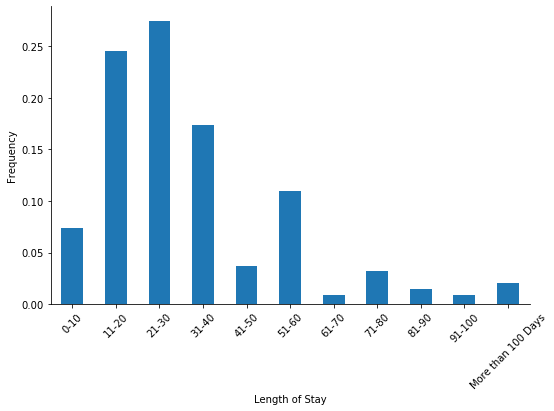

In [20]:
# Target variable distribution
y_train.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(8,6))
plt.rc('font', size=16)
ax = plt.gca()
xticklabels = y_train.value_counts().sort_index().index
ax.set_xticklabels(xticklabels, rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('target_distribution')

In [21]:
def code_binary_target(target, threshold_idx):
    # divides target variable into two classes, splitting sorted labels at threshold_idx
    
    stay_values = np.sort(target.unique())

    short_stays = stay_values[:threshold_idx]
    long_stays = stay_values[threshold_idx:]

    target = target.apply(lambda x: 0 if x in short_stays else 1)
    
    # plot the new 2-category distribution
    xs = [0,1]
    bp = target.value_counts(normalize=True).sort_index().plot(kind='bar')
    for i in xs:
        plt.text(i, bp.patches[i].get_height()+0.01, np.round(bp.patches[i].get_height(),3), ha = 'center')
    plt.ylabel('Percent of target labels')
    plt.tight_layout()
    
    return target

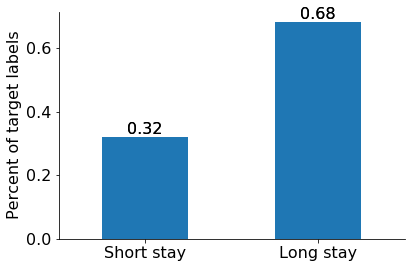

In [22]:
# setting the "long stay" cutoff

y_holdout = code_binary_target(y_holdout, threshold_idx=2)
y_train = code_binary_target(y_train, threshold_idx=2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['Short stay', 'Long stay'], rotation=0)
plt.tight_layout()
plt.savefig('target_binary_distribution.png')

In [23]:
# using the patientid to add the number of previous visits as a feature

for df in [train, holdout]:
    df['visit_number'] = df.groupby('patientid').cumcount()
    df.drop(['case_id', 'patientid'], axis=1, inplace=True)

In [24]:
# ordinal coding for severity of illness

for df in [train, holdout]:
    df['severity'] = df['severity'].map({'Minor': 1, 'Moderate': 2, 'Extreme': 3})

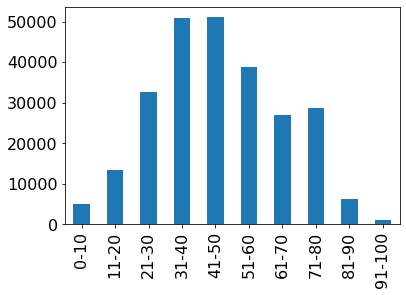

In [25]:
# patient age distribution

train['age'].value_counts().sort_index().plot(kind='bar')

In [26]:
# converting age range string to numeric

for df in [train, holdout]:
    df['age_decades'] = df['age'].str.split('-').apply(lambda x: int(x[0])//10)
    df.drop('age', axis=1, inplace=True)


In [27]:
# Visitors over time leaks info on length of stay

for df in [train, holdout]:
    df = df.drop('visitors', axis=1, inplace=True)


In [28]:
train = pd.get_dummies(train.dropna(axis=0), drop_first=True)
holdout = pd.get_dummies(holdout.dropna(axis=0), drop_first=True)

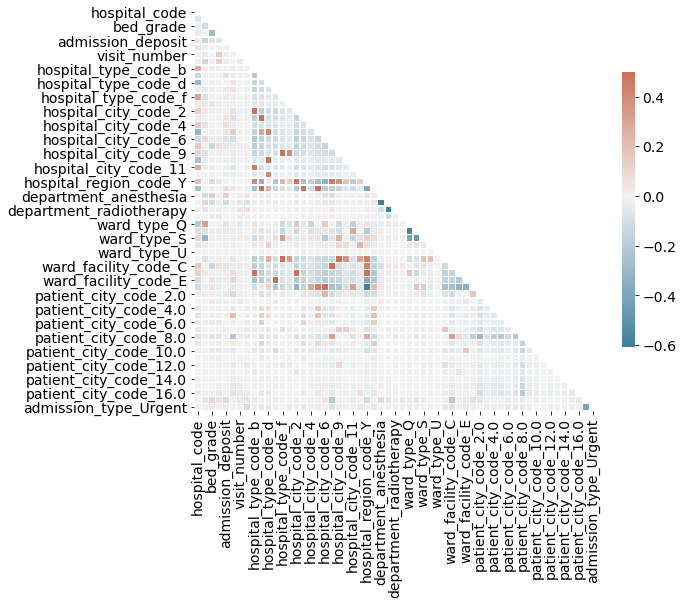

In [29]:
plt.figure(figsize=(10,10))
plt.rc('font', size=14)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(train.corr(), dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

In [30]:
# candidates of dummy variables to combine

r, c = np.where(np.tril(train.corr(), k=-1)>0.8)

pd.DataFrame([(train.columns[x[0]], train.columns[x[1]], np.tril(train.corr())[x[0], x[1]]) 
              for x in zip(r,c)]).sort_values(by=2, ascending=False)

,0,1,2
4,ward_facility_code_C,hospital_city_code_7,1.000000
6,ward_facility_code_D,hospital_city_code_2,1.000000
3,ward_facility_code_B,hospital_city_code_9,0.850228
0,hospital_city_code_2,hospital_type_code_b,0.838490
5,ward_facility_code_D,hospital_type_code_b,0.838490
2,hospital_region_code_Z,hospital_type_code_c,0.828675
1,hospital_city_code_3,hospital_type_code_c,0.809924


In [31]:
# drop redundant columns

for df in [train, holdout]:
    df.drop(['ward_facility_code_C', 'ward_facility_code_D', 'hospital_type_code_c'], axis=1, inplace=True)

In [32]:
def combine_columns(df, col1, col2):
    joined_col = (df[col1] | df[col2]).astype(int)
    col_name = '_'.join([col1, col2])
    col_name = re.sub(r'[Cc]ode_', '', col_name)

    df[col_name] = joined_col
    return df

In [33]:
# combining highly correlated columns

pair = ['ward_facility_code_B','hospital_city_code_9']

train = combine_columns(train, pair[0], pair[1])
holdout = combine_columns(holdout, pair[0], pair[1])

for df in [train, holdout]:
    df.drop(pair, axis=1, inplace=True)

In [34]:
pair = ['hospital_type_code_b','hospital_city_code_2']

train = combine_columns(train, pair[0], pair[1])
holdout = combine_columns(holdout, pair[0], pair[1])

for df in [train, holdout]:
    df.drop(pair, axis=1, inplace=True)

## 2. Training classifier algorithms

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size=0.3, stratify=y_train)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Oversampling minority outcome-- to be validated in a later step

ratio = 1 - y_train.sum()/len(y_train)
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 0.9) 
    
X_train_os, y_train_os = ROS.fit_resample(X_train, y_train)
X_train_scaled_os, y_train_scaled_os = ROS.fit_resample(X_train_scaled, y_train)

In [38]:
def plot_confusion_matrix(actual, pred, labels):
    
    cm = confusion_matrix(actual, pred, labels=labels)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels).plot()
    plt.savefig('confusion_matrix.png')

In [39]:
def train_test_score(model, X, y):
    # trains classifier on X_train, y_train
    # input X, y to use for prediction/scoring
    
    model.fit(X_train, y_train)
    predictions = model.predict(X)
    
    print("Accuracy:", accuracy_score(y, predictions))    
    print("Precision:", precision_score(y, predictions))    
    print("Recall:", recall_score(y, predictions))
    print("F1 score:", f1_score(y, predictions))
    
    plot_confusion_matrix(y, predictions, model.classes_)

In [40]:
class ModelResults():
    
    def __init__(self, model, model_name,
                 X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
        
        self.model = model
        self.name = model_name
        
        self.model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_scores, test_scores = {}, {}
    
        for score in ['accuracy_score', 'precision_score', 'recall_score', 'f1_score']:
            train_scores[score] = eval(score)(y_train, train_pred)
            test_scores[score] = eval(score)(y_test, test_pred)
            
        self.train_scores = train_scores
        self.test_scores = test_scores
        
    def table(self):
        df = pd.DataFrame({'model': self.name, 'train': self.train_scores, 'test': self.test_scores})
        df = df.reset_index().rename(columns={'index': 'score'})
        df.style.background_gradient(cmap ='Blues')
        return df.sort_values(by=['score', 'test'], ascending=False)
  
    def get_model(self):
        return self.model

In [41]:
class ResultsTable():
    
    def __init__(self, results):
        self.df = pd.concat(results, ignore_index=True)
        
    def append(self, results):
        self.df = pd.concat([self.df, results.table()], ignore_index=True)

    def show(self):
        self.df['score'] = pd.Categorical(self.df['score'], 
                                     ['f1_score', 'recall_score', 'precision_score', 'accuracy_score'])

        return self.df.sort_values(by=['score', 'test'],
                                  ascending=[True, False]).style.background_gradient(cmap ='Blues')


Accuracy: 0.6804972194962381
Precision: 0.6804972194962381
Recall: 1.0
F1 score: 0.8098760433536814


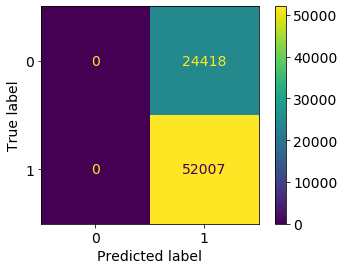

In [42]:
# high baseline scores

print("Accuracy:", accuracy_score(y_test, np.ones(y_test.shape)))    
print("Precision:", precision_score(y_test, np.ones(y_test.shape)))    
print("Recall:", recall_score(y_test, np.ones(y_test.shape)))
print("F1 score:", f1_score(y_test, np.ones(y_test.shape)))
    
plot_confusion_matrix(y_test, np.ones(y_test.shape), [0,1])


In [44]:
# getting results for initial models

models = [(KNeighborsClassifier(n_jobs=-1), 'KNN'),
          (DecisionTreeClassifier(class_weight='balanced'), 
                   'Decision Tree'),
          (LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000, scoring='f1'), 
                   'LogReg')]

model_names = ["knn", "dtree", "logreg", "logregs"]

results_list = []
for i,m in enumerate(models):
    results = ModelResults(*m)
    results_list.append(results.table())
    with open(f"models/{model_names[i]}.pickle", "wb") as pfile:
        pickle.dump(results, pfile)                     

In [45]:
# or load previous results

model_names = ["knn", "dtree", "logreg", "logregs"]

results_list = []
for m in model_names:
    with open(f"models/{m}.pickle", "rb") as pfile:
        exec(f"{m} = pickle.load(pfile)")
        exec(f"results_list.append({m}.table())")

In [46]:
# getting results for ensemble models

ensembles = [(RandomForestClassifier(class_weight='balanced'), 'Random Forest'),
              (ExtraTreesClassifier(class_weight='balanced'), 'Extra Trees')]
ensemble_names = ["rf", "extra_trees"]

for m in ensembles:
    results = ModelResults(*m)
    results_list.append(results.table())
    model_object = results.get_model()
    with open(f"models/{m[1]}.pickle", "wb") as pfile:
        pickle.dump(model_object, pfile) 

In [46]:
# or load previously trained ensemble models

ensemble_names = ["rf", "extra_trees"]

for e in ensemble_names:
    with open(f"models/{e}.pickle", "rb") as pfile:
        exec(f"{e} = pickle.load(pfile)")
        
results_list.append(ModelResults(rf, 'Random Forest').table())
results_list.append(ModelResults(extra_trees, 'Extra Trees').table())

In [47]:
df = ResultsTable(results_list)
df.show().hide_index()

# save df image
# dfi.export(df.show().hide_index(), 'df_styled.png')

score,model,train,test
f1_score,Random Forest,0.999946,0.791145
f1_score,Extra Trees,0.999951,0.770559
f1_score,KNN,0.831132,0.753561
f1_score,Decision Tree,0.999951,0.711835
f1_score,LogReg,0.682905,0.680345
f1_score,LogReg scaled,0.676190,0.677656
recall_score,Random Forest,0.999942,0.878920
recall_score,Extra Trees,0.999901,0.827062
recall_score,KNN,0.902010,0.820409
recall_score,Decision Tree,0.999901,0.712116


So far a classifier based on decision trees seems much more promising than logistic regression.

The baseline f1 score is still higher than any of the models, and the best-performing model, the Random Forest classifier, is strongly overfitting training data.

Next steps:
- tuning random forest hyperparameters
- accounting for imbalanced classes
- gradient boosting
- validating added feature and oversampling

## 3. Random Forest hyperparameter tuning

In [52]:
f1_scores = []

for i in range(1, 50):
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    f1_scores.append(f1_score(y_test, rf.predict(X_test)))
    

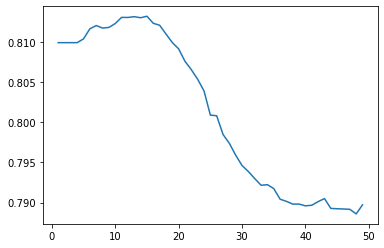

In [53]:
plt.plot(range(1,50), f1_scores)

In [55]:
# random search across hyperparameter grid

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [4, 8, 10, 12, 14, 16]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 6, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [56]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv=3, 
                               random_state=42, n_jobs = 4, verbose=2)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 8, 10, 12, 14, 16],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 287, 525, 762,
                                                         1000]},
                   random_state=42, verbose=2)

In [ ]:
# or load previously trained model

with open(f"models/rf_random.pickle", "rb") as pfile:
    exec(f"rf_random = pickle.load(pfile)")

In [58]:
with open(f"models/rf_random.pickle", "wb") as pfile:
        pickle.dump(rf_random, pfile)

In [57]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': False}

Accuracy: 0.6999280340202814
Precision: 0.7062688007264885
Recall: 0.9570827004057146
F1 score: 0.8127658532204469


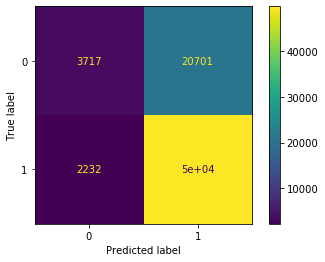

In [59]:
train_test_score(rf_random.best_estimator_, X_test, y_test)

Accuracy: 0.6838992476283938
Precision: 0.7205232567347133
Recall: 0.8748053146691791
F1 score: 0.790204081632653


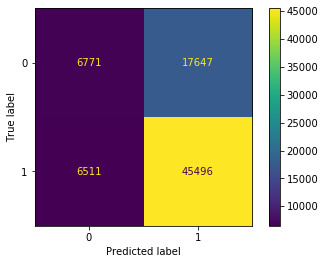

In [60]:
train_test_score(RandomForestClassifier(), X_test, y_test)

Accuracy: 0.6829178933595028
Precision: 0.7178763061282124
Recall: 0.8798046416828503
F1 score: 0.790634584647285


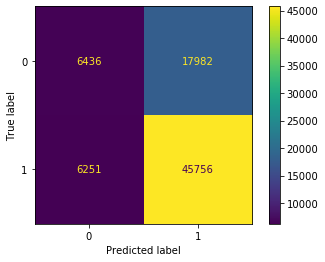

In [61]:
train_test_score(RandomForestClassifier(class_weight='balanced'), X_test, y_test)

The best result from the randomized grid search works better than the baseline Random Forest, and only a little better than the overall baseline (guessing only majority class). 

In [64]:
res= ModelResults(rf_random.best_estimator_, 'RF random search')

In [65]:
df.append(res)
df.show()

,score,model,train,test
22,f1_score,RF random search,0.841375,0.812831
14,f1_score,Random Forest,0.999922,0.792267
18,f1_score,Extra Trees,0.999930,0.770902
2,f1_score,Decision Tree,0.999930,0.711082
6,f1_score,LogReg,0.668071,0.669198
10,f1_score,LogReg scaled,0.668071,0.669198
20,recall_score,RF random search,0.977602,0.956910
12,recall_score,Random Forest,0.999876,0.881766
16,recall_score,Extra Trees,0.999860,0.829023
0,recall_score,Decision Tree,0.999860,0.709885


In [66]:
# training XGBoost model for comparison

param = {'alpha':1, 'eta':0.5, 'objective':'binary:logistic'}
num_round = 100

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(param, dtrain, num_round)
# make prediction
soft_preds = bst.predict(dtest)
preds = (soft_preds>0.5).astype(int)

[21:54:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
f1_score(y_test, preds)

0.8033477100020538

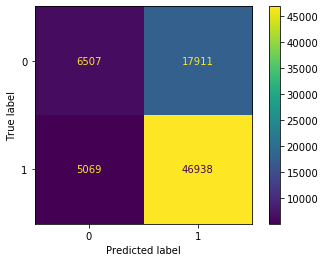

In [68]:
plot_confusion_matrix(y_test, preds,[0,1])

## 4. Validating oversampling and feature engineering

Accuracy: 0.6696892378148511
Precision: 0.7636696813855884
Recall: 0.7452266041109851
F1 score: 0.754335428871718


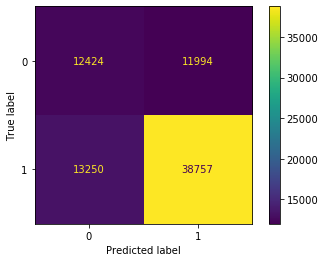

In [82]:
# oversampling data worsened f1 score

model = rf_random.best_estimator_
model.fit(X_train_os, y_train_os)
predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))    
print("Precision:", precision_score(y_test, predictions))    
print("Recall:", recall_score(y_test, predictions))
print("F1 score:", f1_score(y_test, predictions))

plot_confusion_matrix(y_test, predictions, model.classes_)

In [97]:
# Feature importances

pd.DataFrame(list(zip(X_train.columns, rf_random.best_estimator_.feature_importances_))).sort_values(by=1,
                                                                                            ascending=False).head(10)

,0,1
4,admission_deposit,0.146717
3,severity,0.086180
47,patient_city_code_16.0,0.086100
6,visit_number,0.076023
2,bed_grade,0.069653
0,hospital_code,0.067901
5,same_city,0.060639
1,extra_rooms,0.049047
15,hospital_city_code_6,0.046379
38,patient_city_code_7.0,0.030728


Accuracy: 0.7002551521099116
Precision: 0.7067072044553682
Recall: 0.9564673986194167
F1 score: 0.8128339624491396


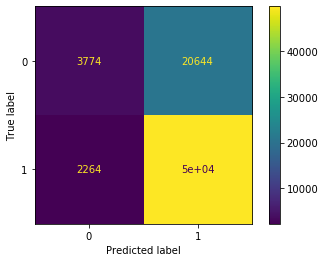

In [96]:
# the "same city" variable seemed to decrease performance too

rf_random.best_estimator_.fit(X_train.drop('same_city', axis=1), y_train)
predictions = rf_random.best_estimator_.predict(X_test.drop('same_city', axis=1))

print("Accuracy:", accuracy_score(y_test, predictions))    
print("Precision:", precision_score(y_test, predictions))    
print("Recall:", recall_score(y_test, predictions))
print("F1 score:", f1_score(y_test, predictions))

plot_confusion_matrix(y_test, predictions, [0,1])

## 5. Holdout set results

Accuracy: 0.6979493782188168
Precision: 0.7039569441153573
Recall: 0.9597360345185629
F1 score: 0.812184525262387


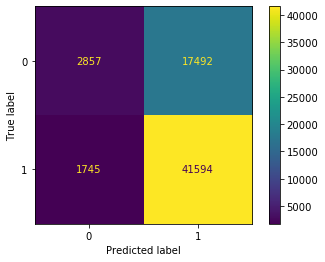

In [98]:
rf_random.best_estimator_.fit(X_train.drop('same_city', axis=1), y_train)
predictions = rf_random.best_estimator_.predict(holdout.drop('same_city', axis=1))

print("Accuracy:", accuracy_score(y_holdout, predictions))    
print("Precision:", precision_score(y_holdout, predictions))    
print("Recall:", recall_score(y_holdout, predictions))
print("F1 score:", f1_score(y_holdout, predictions))

plot_confusion_matrix(y_holdout, predictions, [0,1])